# Model M2

Helper functions, plots, probability distributions

In [67]:
%run Helper_functions_M2.ipynb

In [68]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from torch.distributions import Bernoulli
from functools import reduce
from operator import __or__
from itertools import cycle

n_labels = 10 
n = 10 # How many of each label
# Flatten the images into a vector, using the Bernoulli distribution to binarize it.
flatten = lambda x: Bernoulli(ToTensor()(x).view(28**2)).sample()

# Define the train and test sets, onehot encodes labels right away.
dset_train = MNIST("./", train=True,  transform=flatten, download=True,target_transform=onehot(n_labels))
dset_test  = MNIST("./", train=False, transform=flatten, target_transform=onehot(n_labels))

def Sampler(labels, n=None):
    (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])
    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler

batch_size = 64
labelled = DataLoader(dset_train, batch_size=batch_size,
                                sampler=Sampler(dset_train.train_labels.numpy(),n))

unlabelled = DataLoader(dset_train, batch_size=batch_size,
                          sampler=Sampler(dset_train.train_labels.numpy()))

validation  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=Sampler(dset_test.test_labels.numpy()))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [69]:
class Encoder(nn.Module):
    def __init__(self, dims, sample_layer=GaussianSample):
        # encoder network p(z|x)
        super(Encoder, self).__init__()
        [x_dim, h_dim, z_dim] = dims     
        self.fc1 = nn.Linear(x_dim,h_dim[0])
        self.fc2 = nn.Linear(h_dim[0],h_dim[1])
        self.sample = sample_layer(h_dim[-1], z_dim) #Reparameterizationtrick. 

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)    
        return self.sample(x)

class Decoder(nn.Module):
    def __init__(self, dims):
        #Decoder network p(x|z)
        super(Decoder, self).__init__()
        [z_dim, h_dim, x_dim] = dims

        self.fc1 = nn.Linear(z_dim,h_dim[0])
        self.fc2 = nn.Linear(h_dim[0],h_dim[1])
        self.fc3 = nn.Linear(h_dim[1], x_dim)

          
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return self.output_activation(x)

class Classifier(nn.Module):
    def __init__(self, dims):
        #Classification network p(y|x) 
        super(Classifier, self).__init__()
        [x_dim, h_dim, y_dim] = dims
        self.fc1 = nn.Linear(x_dim, h_dim)    
        self.fc2 = nn.Linear(h_dim, y_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x


In [70]:
class SSVAE(nn.Module):  
    def __init__(self, dims):      
        [x_dim, y_dim, z_dim, h_dim] = dims

        super(SSVAE, self).__init__()
        #Initializing
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        self.encoder = Encoder([x_dim+y_dim, h_dim, z_dim])
        self.decoder = Decoder([z_dim+y_dim,list(reversed(h_dim)),x_dim])
        self.classifier = Classifier([x_dim,h_dim[0],y_dim])

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x, y):
        z, z_mu, z_log_var = self.encoder(torch.cat([x, y], dim=1))
        x_mu = self.decoder(torch.cat([z, y], dim=1))

        return x_mu,z,z_mu,z_log_var

    def classify(self, x):
        logits = self.classifier(x)
        return logits

    def sample(self, z, y):
        y = y.float()
        x = self.decoder(torch.cat([z, y], dim=1))
        return x

In [71]:
x_dim = 784
y_dim = 10
z_dim = 5
h_dim = [256, 128]

vae = SSVAE([784, y_dim, z_dim, h_dim])
vae

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


SSVAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=5, bias=True)
      (log_var): Linear(in_features=128, out_features=5, bias=True)
    )
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [72]:
 class VariationalInference(nn.Module):
    def __init__(self, model,likelihood=F.binary_cross_entropy):
        super(VariationalInference,self).__init__()
        self.model = model
        self.likelihood = likelihood

        
    def forward(self, x, y=None):
        x_dim = 784
        z_dim = 5
        h_dim = [256, 128]
        #Statement to check if y is labelled or unlabelled
        is_labelled = False if y is None else True 
        xs, ys = (x, y)
        if not is_labelled: #similar to summing over all y possibilities if unlabelle
          ys = enumerate_discrete(xs,self.model.y_dim)
          xs = xs.repeat(self.model.y_dim, 1)

        x_mu,z,z_mu,z_log_var = self.model(xs,ys)
                
        # q(z,y|x)        
        qz = log_gaussian(z, z_mu, z_log_var)
        # p(z)
        pz = log_standard_gaussian(z)

        # p(x|y,z)
        likelihood = -self.likelihood(x_mu, xs)
        # p(y)
        prior = -log_standard_categorical(ys)

        elbo = likelihood + prior - (qz - pz)

        L = elbo

        if is_labelled:
          return torch.mean(L)

        logits = self.model.classify(x)
        L = L.view_as(logits.t()).t()

        H = -torch.sum(torch.mul(logits, torch.log(logits + 1e-8)), dim=-1)
        L = torch.sum(torch.mul(logits, L), dim=-1)

        U = L + H
        return torch.mean(U)

In [73]:
alpha = 0.1 * n*10

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4, betas=(0.9, 0.999))

vi = VariationalInference(vae,likelihood=binary_cross_entropy)

In [74]:
start = timeit.timeit()

epoch = 0
num_epochs = 25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)
#Init lists
losses, losses_val, U_list,L_list, accuracy_list,accuracy_val_list = [], [], [], [], [], []
#init confusion matrix lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

while epoch < num_epochs:
    #--------------------------------train------------------------------ 
    
    total_loss, accuracy, U_epoch, L_epoch = (0, 0, 0, 0)
    epoch+= 1
    vae.train()
    #Looping through labelled and unlabelled batches
    for (x,y),(u,_) in zip(cycle(labelled),unlabelled):

        x, y, u = Variable(x), Variable(y), Variable(u)

        L = -vi(x,y) #Inference, loss labelled data
        L_epoch += L.item()
        U = -vi(u) #Inference, loss unlabelled data
        U_epoch += U.item()
        # classification q(y|x)
        logits = vae.classify(x) #Classifying x for labelled data

        # Regular cross entropy to find classification loss between label y and classified x
        classification_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()
        #Total loss
        J_alpha = L - alpha*classification_loss + U
        
        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.item()
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
    print(epoch)
    print('accuracy', accuracy/len(unlabelled))
    
    #----------------------------- eval-----------------------------------
    vae.eval()
    total_loss_val, accuracy_val = (0, 0)
    for x_, y_ in validation:
        x_, y_ = Variable(x_), Variable(y_)
        L = -vi(x_,y_) 
        U = -vi(x_)
        logits = vae.classify(x_)
        classication_loss = torch.sum(y_ * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L - alpha * classication_loss + U

        total_loss_val += J_alpha.item()
        pred = torch.max(logits, 1)[1].data
        test_val = torch.max(y_, 1)[1].data
        accuracy_val += torch.mean((pred == test_val).float())

        #Confusion matrix for last epoch only
        if epoch == num_epochs: #Confusion matrix
          predlist=torch.cat([predlist,pred.view(-1).cpu()])
          lbllist=torch.cat([lbllist,test_val.view(-1).cpu()])
        
    print('val',accuracy_val/len(validation))
  #-----------------------------plotting --------------------------
    accuracy_val_list.append(accuracy_val/len(validation))
    accuracy_list.append(accuracy/len(unlabelled))
    U_list.append(-U_epoch)
    L_list.append(-L_epoch)
    losses_val.append(-(total_loss_val/(len(validation)*batch_size)))
    losses.append(-(total_loss/(len(unlabelled)*batch_size)))
    z,z_mu,z_log_var = vae.encoder(torch.cat([x,y],dim=1))
    x_mu = vae.sample(z,y)
    outputs = {'z':z,'px':x_mu,'losses':losses,'losses_val':losses_val,'L_list':L_list,'U_list':U_list}
    y_plot = (torch.max(y, 1)[1].data).detach().numpy()

    make_plot(vae,x,y_plot,outputs)

end = timeit.timeit()
print(end - start)

0.006841550000899588


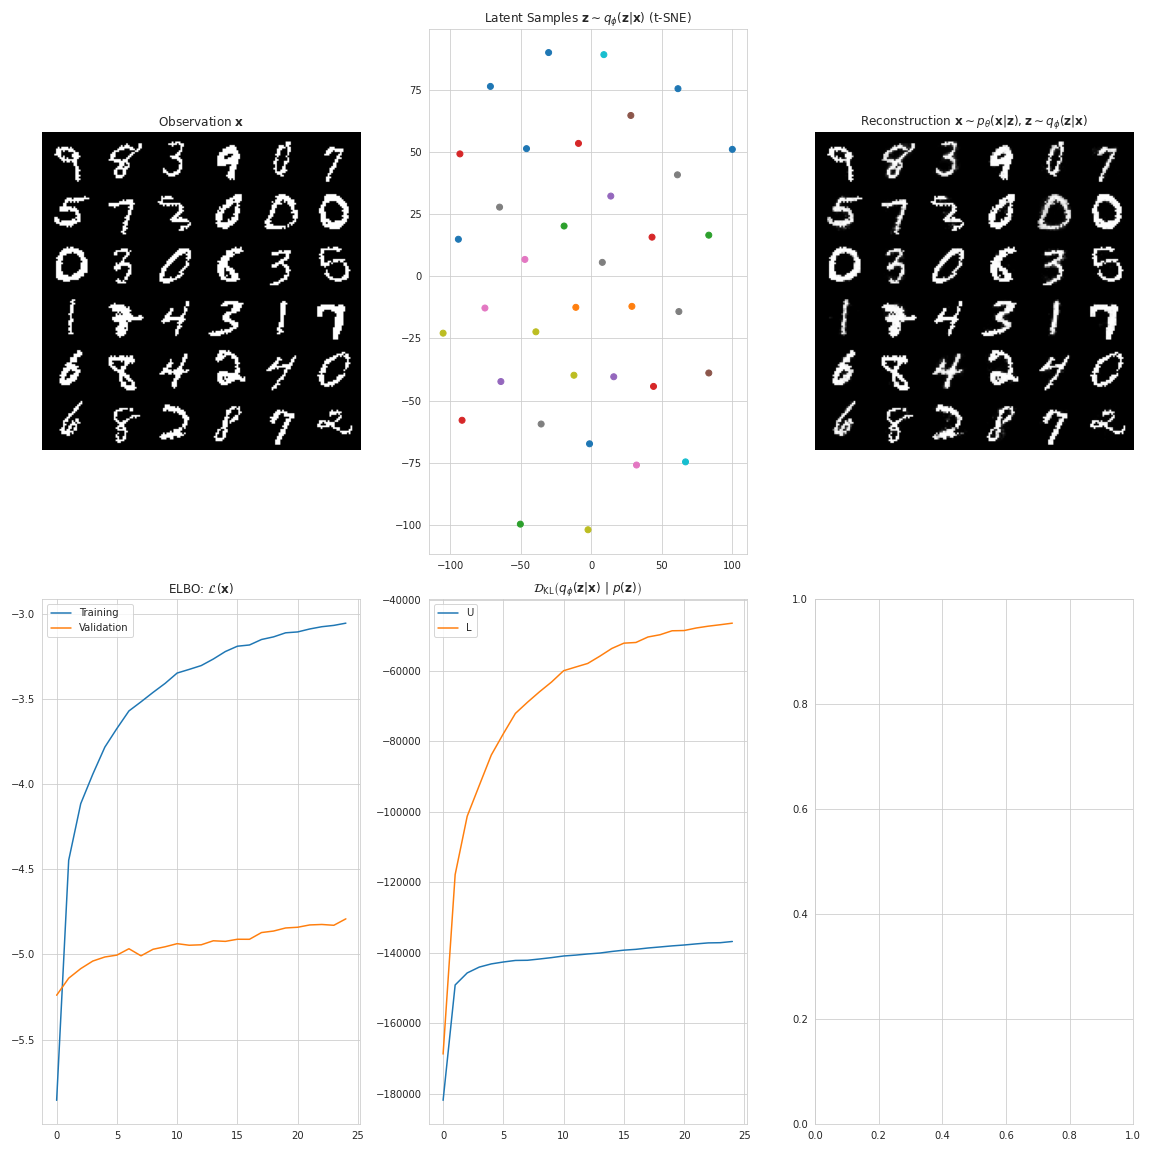

In [75]:
 make_plot(vae,x,y_plot,outputs)

### Confusion matrix

In [76]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 961    0    0    0    0    4    7    1    5    2]
 [   0 1093    0    2    1    1    5    0   33    0]
 [   8    0  508   27    7    5   17   16  407   37]
 [   1    0    5  894    0   40    3   11   45   11]
 [   1    0    1    0  790    0   15    4    4  167]
 [   3    2    0   23    2  802   21    2   22   15]
 [   8    3    0    0    2    4  934    1    5    1]
 [   0    7    5    6    5    1    0  930   17   57]
 [   4    1    3   13    5   28   10    5  888   17]
 [   3    7    0   16   11    2    1   35   14  920]]
[98.06122449 96.29955947 49.2248062  88.51485149 80.44806517 89.9103139
 97.49478079 90.46692607 91.17043121 91.17938553]


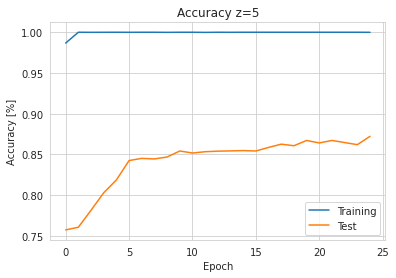

In [77]:
plt.plot(accuracy_list, label='Training')
plt.plot(accuracy_val_list, label='Test')
plt.title('Accuracy z={}'.format(z_dim))
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.legend()
plt.show()

### Accuracy plot for report.

In [78]:
#Numbers from earlier runs. Saved in list to avoid having to rerun everything. 
# lst_100 = [0.7389,0.7667,0.8029,0.8237,0.8361,0.8396,0.8443,0.8438,0.8513,0.8573,0.8605,0.8605,0.8643,0.8682,0.8593,0.8692,0.8692,0.8740,0.8786]
lst_100 = [0.7641, 0.7757, 0.787, 0.8146,0.8175, 0.8279, 0.8287, 0.8311, 0.8384, 0.839, 0.8426, 0.8446, 0.8445, 0.8555, 0.8496, 0.8449, 0.8616, 0.8673, 0.8631, 0.8671, 0.8589, 0.8658, 0.8652, 0.8712, 0.8704]
lst_500 = [0.8538, 0.8693, 0.8752, 0.8828,0.8917, 0.8939, 0.8982, 0.9073, 0.9139, 0.9112, 0.9203, 0.9206,0.919,0.9199,0.9174,0.924,0.9258,0.9232,0.9245,0.9246,0.9285,0.9254,0.926,0.9276,0.9253]

lst_1000 = [0.8694,0.8794,0.8837,0.8955,0.8993,0.9075,0.9125,0.9219,0.9199,0.9224,0.9319,0.9324,0.9308,0.9324,0.9346,0.9372,0.9375,0.9387,0.9380,0.9384,0.9412,0.9413,0.9427,0.9417]
lst_10000 = [0.8348,0.8762,0.8938,0.9074,0.9108,0.9245,0.9346,0.9369,0.9388,0.9448,0.9451,0.9479,0.9514,0.9491,0.9539,0.9525,0.9517,0.9553,0.9523,0.9561,0.9599,0.9560,0.9590,0.9577]

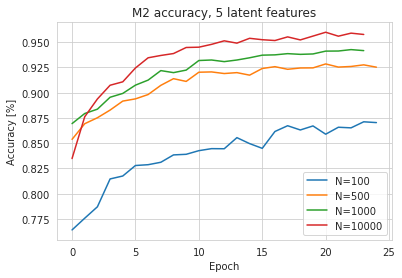

In [79]:
plt.plot(lst_100,label='N=100')
plt.plot(lst_500,label='N=500')
plt.plot(lst_1000,label='N=1000')
plt.plot(lst_10000,label = 'N=10000')
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('M2 accuracy, 5 latent features')
plt.legend()
plt.savefig('accuracy_m2.jpg')
plt.show()

### Generative plots

Style transfer

(10, 28, 28)


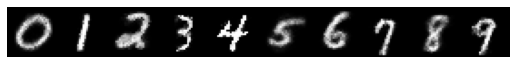

In [80]:
x__ = torch.empty(0)
z__ = torch.empty(0)
for i in range(10):
  z = Variable(torch.randn(1, z_dim)+1.2*torch.randn(1))
  y = Variable(onehot(10)(i).repeat(1, 1))
  x_mu = vae.sample(z, y)
  x__ = torch.cat([x__,x_mu],dim=0)
  z__ = torch.cat([z__,z],dim=0)

f, axarr = plt.subplots(1, 10,figsize=(9,10))

samples = x__.data.view(-1, 28, 28).numpy()
print(samples.shape)
for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i],cmap='gray')
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig('values.jpg')
plt.show()

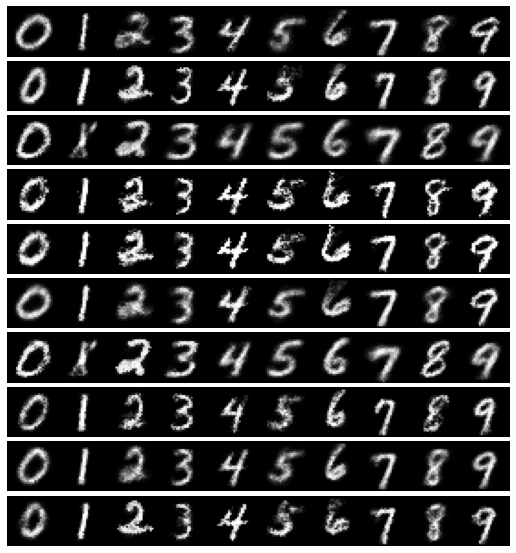

In [81]:
vae.eval()
ts = torch.empty(0)

for j in range(10):
  for i in range(10):

    y = Variable(onehot(10)(i).repeat(1, 1))
    x_mu = vae.sample(z__[j].repeat(1,1), y)
    ts = torch.cat([ts,x_mu],dim=0)


f, axarr = plt.subplots(10, 10,figsize=(9,10))

samples = ts.data.view(-1, 28, 28).numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i],cmap='gray')
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# plt.savefig('generated.jpg')
plt.show()

Linear increase in z-latent features. -1 to 1

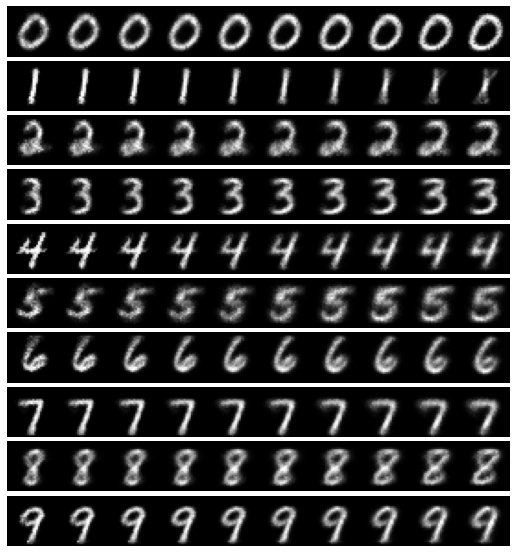

In [82]:
vae.eval()
ts = torch.empty(0)

for i in range(10):
  # z = Variable(torch.randn(10, 50))
  z,z2 = torch.meshgrid(torch.linspace(-1,1,10),torch.linspace(-1,1,z_dim))
  # Generate a batch of 7s
  y = Variable(onehot(10)(i).repeat(10, 1))
  x_mu = vae.sample(z, y)
  ts = torch.cat([ts,x_mu],dim=0)



f, axarr = plt.subplots(10, 10,figsize=(9,10))

samples = ts.data.view(-1, 28, 28).numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i],cmap='gray')
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# plt.savefig('generated.jpg')
plt.show()